# Keras Subclassing API

## Classify images with a toy ResNet

In this notebook, we will train a reduced version of the popular ResNet neural network, which uses residual connections, to classify images from the CIFAR10 dataset. The main difference between this notebook and the previous one is the use of the Subclassing API instead of the Functional one.

##### Import the required modules

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2021-12-22 12:29:21.889631: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-22 12:29:21.889654: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


##### Download the CIFAR10 Dataset

As in the previous notebook, will use the `keras.datasets` package to download the dataset. We will also do some (manual) normalization of the data. Notice that it's actually better to use a `Normalization()` Keras layer, so that the input pipeline remains part of your model (more portable). But this will do for a simple example.

The `to_categorical` method applies one-hot encoding to the integer class labels. 

In [2]:
(x_train, y_train_int), (x_test, y_test_int) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = keras.utils.to_categorical(y_train_int, 10)
y_test = keras.utils.to_categorical(y_test_int, 10)

170508288/170498071 [==============================] - 641s 4us/step



CIFAR10 contains 32x32 color images, so the shape of `x_train` and `x_test` is $(n_{images}, 32, 32, 3)$, whereas the shape of `y_train` and `y_test` is $(n_{images}, 10)$ because of the one-hot encoding.

In [3]:
print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 10)


Let us define the class names (they are not defined in the dataset)

In [4]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

Finally, let us plot some images as an example. Wow, the resolution is quite low...!

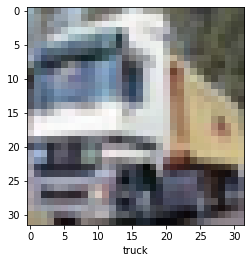

In [5]:
idx = 1
plt.figure()
plt.imshow(x_train[idx])
plt.xlabel(class_names[y_train_int[idx][0]])
plt.grid(False)
plt.show()

##### Let us build a small ResNet-like CNN model with the Subclassing API

ResNet-like networks are constructed as a stack of blocks each with the same structure.

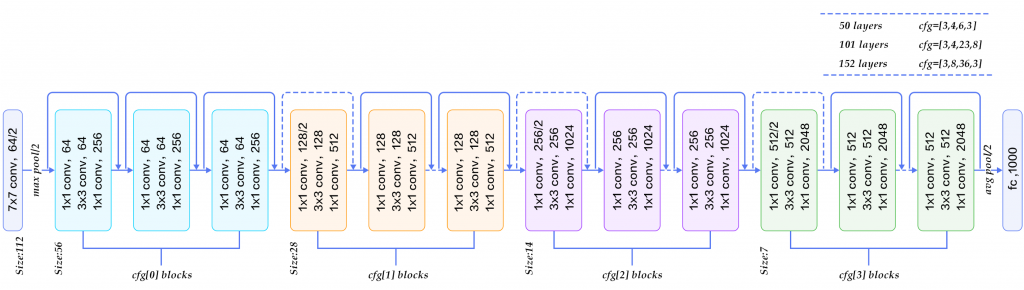

So, let us first define one of these blocks as a custom `keras.layers.Layer`. Ours will be simpler than the original ResNet one (no 1x1 convolutions, batch normalization, etc).

Notice that in the slides, we defined a custom layer that used core TF ops internally. Here, we show that a custom layer can also contain high-level Keras layers.

In [6]:
class ResNetBlock(keras.layers.Layer):
    def __init__(self, filters):
        super(ResNetBlock, self).__init__()
        filters1, filters2 = filters
        # first 3x3 conv
        self.conv2a = keras.layers.Conv2D(filters1, 3, activation='relu', padding='same')
        # second 3x3 conv
        self.conv2b = keras.layers.Conv2D(filters2, 3, activation='relu', padding='same')

    # we don't need a build function since conv layers weights tensors shapes don't depend on the input shape 
        
    def call(self, inputs):
        x = self.conv2a(inputs)
        x = self.conv2b(x)
        # residual connection implemented here
        x += inputs
        return x

Let us now define the entire toy ResNet model as a custom `keras.Model` which uses the `ResNetBlock` internally. We will use the same architecture as in the previous notebook. Note that at this point, we could have use either the Sequential or Functional APIs to build the model.

In [7]:
class ResNet(keras.Model):

    def __init__(self):
        super(ResNet, self).__init__()
        self.conv_1    = keras.layers.Conv2D(32, 3, activation="relu")
        self.conv_2    = keras.layers.Conv2D(64, 3, activation="relu")
        self.maxpool   = keras.layers.MaxPooling2D(3)
        self.block_1   = ResNetBlock((64, 64))
        self.block_2   = ResNetBlock((64, 64))
        self.conv_3    = keras.layers.Conv2D(64, 3, activation='relu')
        self.glopool   = keras.layers.GlobalAveragePooling2D()
        self.dense_1   = keras.layers.Dense(256, activation="relu")
        self.do        = keras.layers.Dropout(0.5)
        self.dense_2   = keras.layers.Dense(10)

    def call(self, inputs):
        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.maxpool(x)
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.conv_3(x)
        x = self.glopool(x)
        x = self.dense_1(x)
        x = self.do(x)
        x = self.dense_2(x)
        return x

Let us create an instance of the model. In general we cannot show summary or plot the model with this API.

In [8]:
model = ResNet()

2021-12-22 12:40:10.097834: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-22 12:40:10.097853: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-22 12:40:10.097867: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (matteo-Inspiron-7591-2n1): /proc/driver/nvidia/version does not exist
2021-12-22 12:40:10.097999: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


##### Compile the model

Let us now compile the model, specifying optimizer, loss function and metrics.

Notice that, differently from the previous notebook, we use `RMSprop` instead of `Adam` this time. We also use the `CategoricalCrossentropy` loss (not the "sparse" variant) since we have generated 1-hot labels, and we use the `from_logits` option because the last layer of the model does not include a softmax activation. This approach is normally more stable from a numerical point of view, so it's suggegested.


In [9]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

##### Train the model

Notice the new option `validation_split=0.2`. More details on this later.

In [10]:
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2)

2021-12-22 12:40:10.803917: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 491520000 exceeds 10% of free system memory.


Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 1.9172 - accuracy: 0.2753

2021-12-22 12:40:58.711723: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 122880000 exceeds 10% of free system memory.


625/625 [==============================] - 51s 80ms/step - loss: 1.9172 - accuracy: 0.2753 - val_loss: 1.5572 - val_accuracy: 0.4224
Epoch 2/10
625/625 [==============================] - 54s 86ms/step - loss: 1.4988 - accuracy: 0.4509 - val_loss: 1.4320 - val_accuracy: 0.4833
Epoch 3/10
625/625 [==============================] - 54s 86ms/step - loss: 1.2677 - accuracy: 0.5453 - val_loss: 1.1080 - val_accuracy: 0.6023
Epoch 4/10
625/625 [==============================] - 54s 86ms/step - loss: 1.1088 - accuracy: 0.6074 - val_loss: 1.0127 - val_accuracy: 0.6384
Epoch 5/10
625/625 [==============================] - 56s 90ms/step - loss: 0.9784 - accuracy: 0.6557 - val_loss: 0.8749 - val_accuracy: 0.6967
Epoch 6/10
625/625 [==============================] - 56s 89ms/step - loss: 0.8809 - accuracy: 0.6934 - val_loss: 1.0247 - val_accuracy: 0.6596
Epoch 7/10
625/625 [==============================] - 56s 90ms/step - loss: 0.8069 - accuracy: 0.7214 - val_loss: 0.7329 - val_accuracy: 0.7445
Epo

##### Evaluate on unseen data

Let us test the model on unseen data using the `evaluate()` method. The model is slightly over-fitting the training data.

In [11]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

2021-12-22 12:49:30.573848: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 122880000 exceeds 10% of free system memory.


313/313 - 3s - loss: 0.8735 - accuracy: 0.7339 - 3s/epoch - 10ms/step

Test accuracy: 0.7339000105857849


##### Perform a prediction on a single image

Let us run a prediction on one image and see the result. Notice that the bar chart is negative this time because we have logits, not probabilities.

Predicted label: 6 (frog)
Real label: 6 (frog)


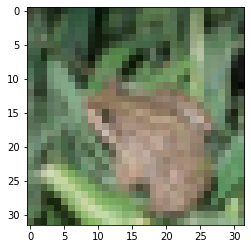

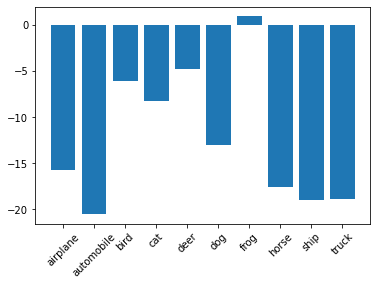

In [12]:
idx = 4

pred = model.predict(x_test[idx].reshape(1, 32, 32, 3))
pred_lidx = tf.argmax(pred[0])
pred_label = class_names[pred_lidx]

print("Predicted label: {} ({})".format(pred_lidx, pred_label))
print("Real label: {} ({})".format(y_test_int[idx][0], class_names[y_test_int[idx][0]]))

plt.figure()
plt.imshow(x_test[idx])
plt.grid(False)
plt.figure()
plt.bar(range(len(class_names)), pred[0], tick_label=class_names)
plt.xticks(rotation=45)
plt.show()